# Water Observations from Space (WOfS)
Using Geoscience Australia [WOfS algorithm](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/virtualproduct.py).

This notebook requires the "UNHAS Environment" to be set in the top-right corner. To create this environment and install the required dependencies, open a terminal window `File-->New-->Terminal` and execute `datacube-notebooks/Ronnie/install_wofs.sh`.

# Table of contents
* [Data parameters - Lake Tempe](#Data-parameters---Lake-Tempe)
* [Set proxy parameters to access data locally](#Set-proxy-parameters-to-access-data-locally)
* [Start a dask cluster to distribute operations](#Start-a-dask-cluster-to-distribute-operations)
* [Import dependencies and initialise datacube](#Import-dependencies-and-initialise-datacube)
* [Display the region of interest](#Display-the-region-of-interest)
* [Load and display the DEM](#Load-and-display-the-DEM)
* [Load the data](#Load-the-data)
* [Classify WOfS](#Classify-WOfS)
* [Water Observations Summaries](#Water-Observations-Summaries)
  * [Wet counts](#Wet-counts)
  * [Clear observations counts](#Clear-observations-counts)
  * [Wet frequencies](#Wet-frequencies)


## Data parameters - Lake Tempe

In [1]:
product = "landsat8_c2l2_sr"
longitude = (119.8242517, 120.0350519)
latitude = (-4.2013799, -3.9445384)
time = ('2020-01-01', '2020-12-31')
output_crs = "EPSG:32650"
resolution = (30, -30)

# Where to save the DEM fetched in ODC
DEM_PATH = "/home/jovyan/dems/srtm_lake_tempe.tif"

## Set proxy parameters to access data locally

In [2]:
from os import environ

environ["AWS_HTTPS"] = "NO"
environ["GDAL_HTTP_PROXY"] = "easi-caching-proxy.caching-proxy:80"
print(f'Will use caching proxy at: {environ.get("GDAL_HTTP_PROXY")}')

Will use caching proxy at: easi-caching-proxy.caching-proxy:80


## Start a dask cluster to distribute operations
The dashboard url allows us to monitor things.

In [3]:
from os import environ
from urllib.parse import urlparse
from dask.distributed import Client, LocalCluster
from IPython.core.display import HTML

cluster = LocalCluster(scheduler_port=0, dashboard_address=":0")
client = Client(cluster)
display(cluster)
if cluster:
    port = urlparse(cluster.dashboard_link).port
    dashboard_url = (
        f'https://hub.sg-dev.easi-eo.solutions/'
        f'{environ["JUPYTERHUB_SERVICE_PREFIX"]}proxy/{port}/status'
    )
    display(HTML(f'Dashboard: <a href={dashboard_url}>{dashboard_url}</a>'))

## Import dependencies and initialise datacube

In [4]:
import sys
sys.path.append("../../hub-notebooks/scripts")

from pathlib import Path

import xarray as xr
import rioxarray

from app_utils import display_map
from wofs.virtualproduct import WOfSClassifier

In [5]:
from datacube import Datacube
from datacube.utils.aws import configure_s3_access

configure_s3_access(
    aws_unsigned=False, 
    requester_pays=True, 
    client=client, 
);

dc = Datacube()

In [6]:
# Display available products
products_info = dc.list_products()
products_info

name  \
name                                   
landsat5_c2l2_sr    landsat5_c2l2_sr   
landsat7_c2l2_sr    landsat7_c2l2_sr   
landsat8_c2l2_sr    landsat8_c2l2_sr   
lpdaac_nasadem        lpdaac_nasadem   
s2_l2a                        s2_l2a   
usgs_aws_ls5c2_sr  usgs_aws_ls5c2_sr   
usgs_aws_ls7c2_sr  usgs_aws_ls7c2_sr   
usgs_aws_ls8c2_sr  usgs_aws_ls8c2_sr   

                                                         description license  \
name                                                                           
landsat5_c2l2_sr   Landsat 5 Collection 2 Level-2 Surface Reflect...    None   
landsat7_c2l2_sr   Landsat 7 USGS Collection 2 Surface Reflectanc...    None   
landsat8_c2l2_sr   Landsat 8 Collection 2 Surface Reflectance, pr...    None   
lpdaac_nasadem           NASADEM Merged DEM Global 1 arc second V001    None   
s2_l2a             Sentinel-2a and Sentinel-2b imagery, processed...    None   
usgs_aws_ls5c2_sr  Landsat 5 USGS Collection 2 Surface Reflectanc...    None   
usgs_aws_ls7c2_sr  Landsat 7 USGS Collection 2 Surface Reflectanc...    None   
usgs_aws_ls8c2_sr  Landsat 8 USGS Collection 2 Surface Reflectanc...    None   

                  default_crs default_resolution  
name                                              
landsat5_c2l2_sr         None               None  
landsat7_c2l2_sr         None               None  
landsat8_c2l2_sr         None               None  
lpdaac_nasadem           None               None  
s2_l2a                   None               None  
usgs_aws_ls5c2_sr        None               None  
usgs_aws_ls7c2_sr        None               None  
usgs_aws_ls8c2_sr        None               None

## Display the region of interest

In [7]:
display_map(x=longitude, y=latitude)

## Load and display the DEM
We load the SRTM DEM data from ODC using the lpdaac driver.
The Lake Tempe area is mostly flat so the DEM can be made optional.

In [8]:
# Ignore shapely deprecation warnings. To be removed at next image update
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from os import environ
from cartopy.crs import PlateCarree
from datacube import Datacube
from datashader import reductions
import holoviews as hv
import hvplot.xarray
import matplotlib.pyplot as plt

dem = dc.load(
    product="lpdaac_nasadem", 
    latitude=latitude,
    longitude=longitude,
    output_crs="epsg:4326", 
    resolution=(-1/3600, 1/3600),
    dask_chunks={'time': 1} # For more on this line, see "A2 - Dask"
)
elevation = dem.elevation.squeeze()
elevation.persist();

In [9]:
options = {
    'title': 'Elevation',
    'width': 800,
    'height': 500,
    'aspect': 'equal',
    'cmap': plt.cm.terrain,
    'clim': (0, elevation.max().values.item()),    # Limit the color range depending on the layer_name
    'colorbar': True,
    'tools': ['hover'],
}
plot_crs = PlateCarree()
elevation.hvplot.image(
     x = 'longitude', y = 'latitude',         # Dataset x,y dimension names 
     crs = plot_crs,
     rasterize = True,                        # If False, data will not be reduced. This is slow to load but all data is loaded.
     aggregator = reductions.mean(),          # Datashader calculates the mean value for reductions (also first, min, max, las, std, mode)
     precompute = True,                       # Datashader precomputes what it can
    ).opts(**options).hist(bin_range = options['clim'])

:AdjointLayout
   :DynamicMap   []
      :Image   [longitude,latitude]   (elevation)
   :DynamicMap   []
      :Histogram   [elevation]   (elevation_count)

In [10]:
dem_path = Path(DEM_PATH)
dem_path.parent.mkdir(parents=True, exist_ok=True)
elevation.rio.to_raster(dem_path)

## Load the data
Load the data from ODC and rename bands as needed by the WOfS classifier.

In [11]:
measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']
data = dc.load(
    product=product,
    longitude=longitude,
    latitude=latitude,
    time=time,
    output_crs=output_crs,
    resolution=resolution,
    measurements=measurements,
    dask_chunks={'time': 1},
)

data = data.rename({
    "blue": "nbart_blue",
    "green": "nbart_green",
    "red": "nbart_red",
    "nir": "nbart_nir",
    "swir1": "nbart_swir_1",
    "swir2": "nbart_swir_2",
    "pixel_qa": "fmask",
})
data

<xarray.Dataset>
Dimensions:       (time: 19, y: 951, x: 785)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-09T02:10:26.574371 ... 2020-1...
  * y             (y) float64 -4.65e+05 -4.65e+05 ... -4.366e+05 -4.365e+05
  * x             (x) float64 8.371e+05 8.37e+05 ... 8.136e+05 8.136e+05
    spatial_ref   int32 32650
Data variables:
    nbart_blue    (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_green   (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_red     (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_nir     (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_swir_1  (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    nbart_swir_2  (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
    fmask         (time, y, x) uint16 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
Attributes:
    crs:           EPSG:32650
    grid_mapping:  spatial_ref

## Classify WOfS

In [12]:
transform = WOfSClassifier(c2_scaling=True, dsm_path=DEM_PATH)
# Compute the WOF layer
wofl = transform.compute(data)
wofl

<xarray.Dataset>
Dimensions:      (y: 951, x: 785, time: 19)
Coordinates:
  * y            (y) float64 -4.65e+05 -4.65e+05 ... -4.366e+05 -4.365e+05
  * x            (x) float64 8.371e+05 8.37e+05 8.37e+05 ... 8.136e+05 8.136e+05
  * time         (time) datetime64[ns] 2020-01-09T02:10:26.574371 ... 2020-12...
    spatial_ref  int32 32650
Data variables:
    water        (time, y, x) uint8 dask.array<chunksize=(1, 951, 785), meta=np.ndarray>
Attributes:
    crs:      EPSG:32650

In [13]:
# wofl.water.plot(col="time", col_wrap=5);

## Water observations summaries
The Water Observations Summaries based on [https://github.com/opendatacube/odc-stats/blob/develop/odc/stats/plugins/wofs.py](https://github.com/opendatacube/odc-stats/blob/develop/odc/stats/plugins/wofs.py) are made up of:
- `count_clear`: a count of every time a pixel was observed (not obscured by terrain or clouds)
- `count_wet`: a count of every time a pixel was observed and wet
- `frequency`: what fraction of time (wet/clear) was the pixel wet

In [14]:
# Rename dimensions as required
wofl = wofl.rename({"x": "longitude", "y": "latitude"})

In [15]:
from odc.algo import safe_div, apply_numexpr, keep_good_only

wofl["bad"] = (wofl.water & 0b0111_1110) > 0
wofl["some"] = apply_numexpr("((water<<30)>>30)==0", wofl, name="some")
wofl["dry"] = wofl.water == 0
wofl["wet"] = wofl.water == 128
wofl = wofl.drop_vars("water")
for dv in wofl.data_vars.values():
    dv.attrs.pop("nodata", None)

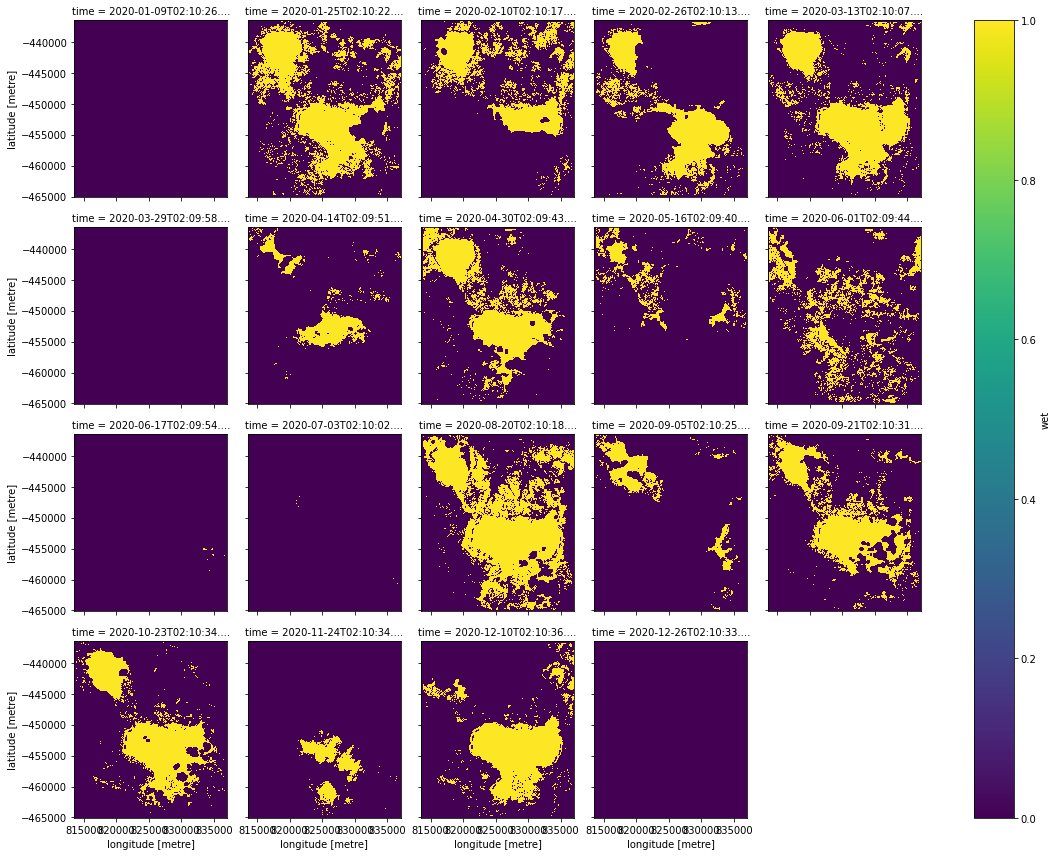

In [16]:
wofl.wet.plot(col="time", col_wrap=5);

In [17]:
# Helper frunction from https://github.com/opendatacube/odc-stats/blob/develop/odc/stats/plugins/wofs.py
def reduce(xx: xr.Dataset) -> xr.Dataset:
    nodata = -999
    count_some = xx.some.sum(axis=0, dtype="int16")
    count_wet = xx.wet.sum(axis=0, dtype="int16")
    count_dry = xx.dry.sum(axis=0, dtype="int16")
    count_clear = count_wet + count_dry
    frequency = safe_div(count_wet, count_clear, dtype="float32")

    count_wet.attrs["nodata"] = nodata
    count_clear.attrs["nodata"] = nodata

    is_ok = count_some > 0
    count_wet = keep_good_only(count_wet, is_ok)
    count_clear = keep_good_only(count_clear, is_ok)

    return xr.Dataset(
        dict(
            count_wet=count_wet,
            count_clear=count_clear,
            frequency=frequency,
        )
    )

In [18]:
summary = reduce(wofl)
summary.persist();

### Wet counts

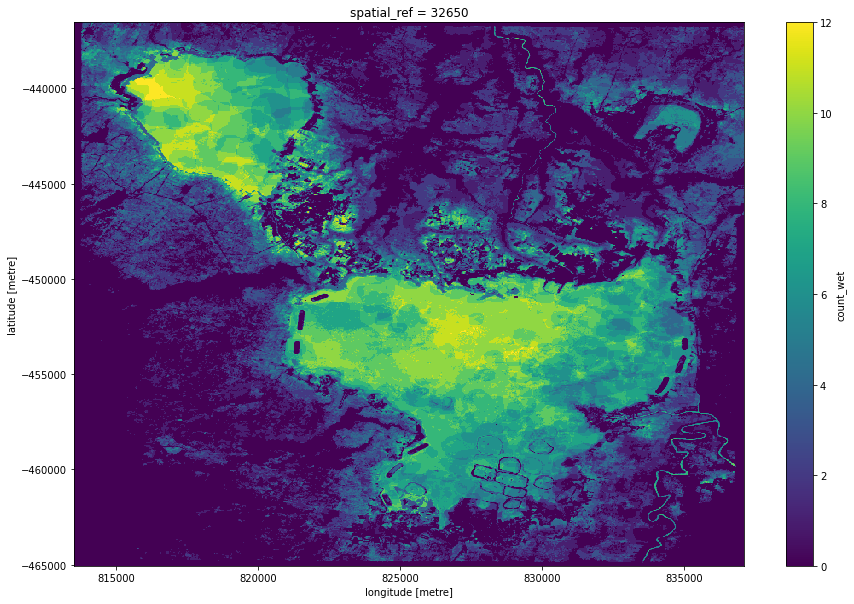

In [19]:
summary.count_wet.plot(size=10);

### Clear observations counts

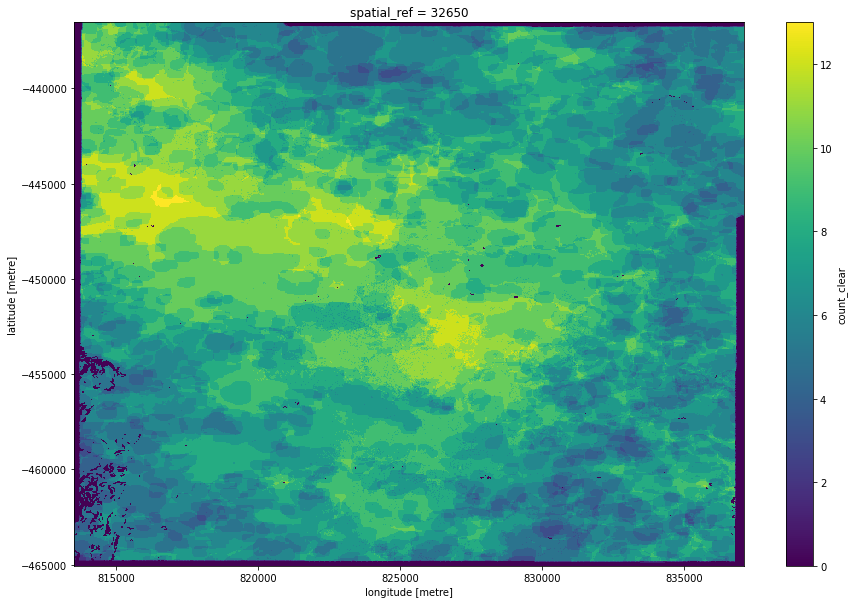

In [20]:
summary.count_clear.plot(size=10);

### Wet frequencies

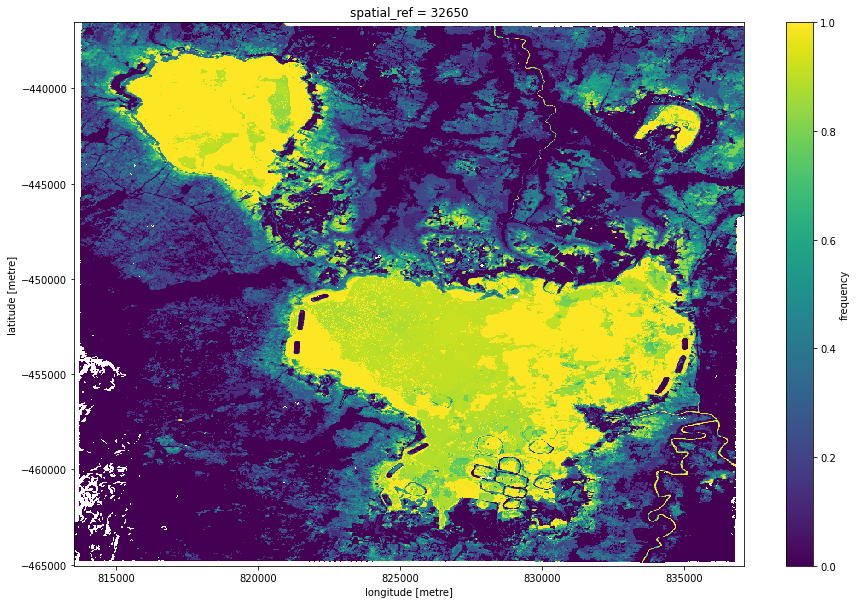

In [21]:
summary.frequency.plot(size=10);